In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc

%load_ext nb_black
use_cuda = True


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_path = "../TabulaSapiensData/"

In [4]:
adata = read_h5ad(data_path + "decontX/Pilot1_Pilot2.decontX.h5ad")

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


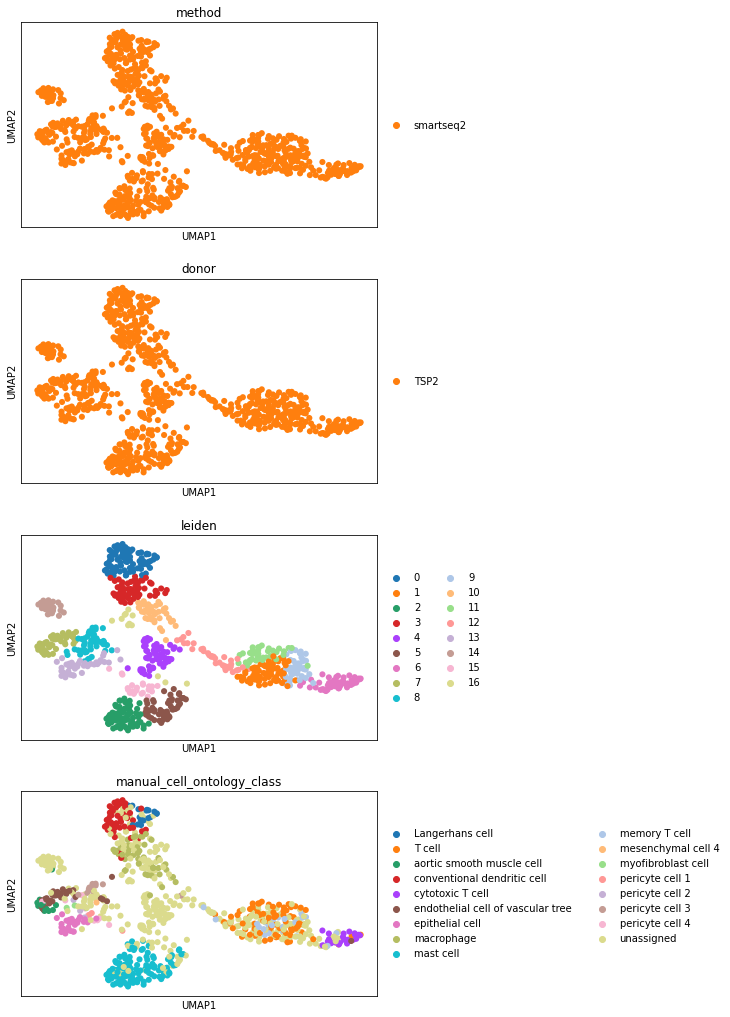

In [5]:
organ = "Skin"
organ_adata = adata[adata.obs["tissue"] == organ]
sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [6]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

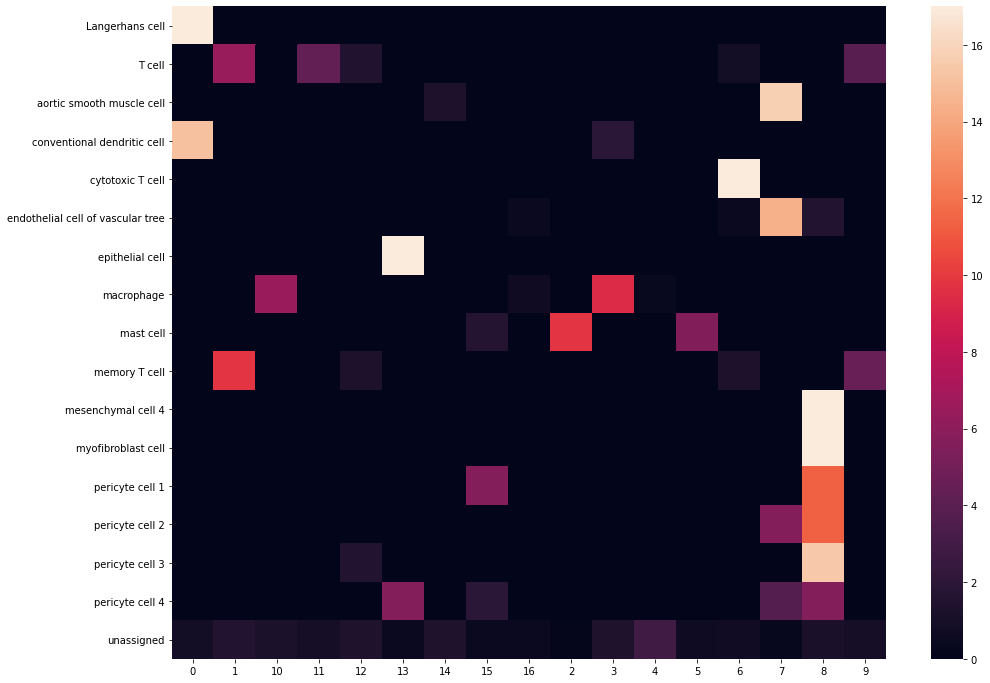

In [7]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.mean(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [8]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [9]:
cluster_composition["0"]

['Langerhans cell: 0.21',
 'conventional dendritic cell: 0.58',
 'unassigned: 0.21']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [10]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [11]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

In [12]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


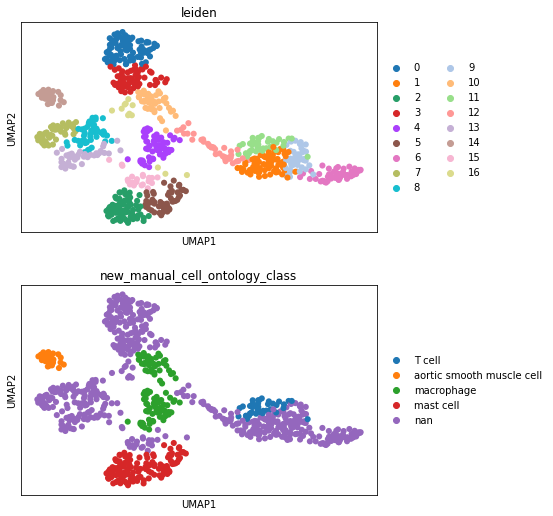

In [13]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

# Sankey Diagram between cluster and cell types

In [14]:
from utils.colorDict import donor_colors, method_colors, compartment_colors, tissue_colors

In [15]:
from utils.plotting_utils import *
from utils.colorDict import compartment_colors

import plotly
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.io as pio

pio.renderers.default = "notebook"

init_notebook_mode(connected=True)

In [16]:
df = pd.DataFrame(columns=["celltype", "compartment", "count"])
for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
    for c in np.unique(organ_adata.obs["compartment_pred_svm"]):
        x = np.sum(
            (organ_adata.obs["compartment_pred_svm"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )
        df = df.append(
            pd.DataFrame([t, c, x], index=["celltype", "compartment", "count"]).T,
            ignore_index=True,
        )


fig = genSankey(
    df,
    cat_cols_color=[compartment_colors(), "#00A1E0"],
    cat_cols=["compartment", "celltype"],
    value_cols="count",
    title="celltype-compartment",
)
iplot(fig, validate=False)
plotly.offline.plot(
    fig, validate=False, filename="figures/celltype_sankey_%s" % organ + ".html"
)  # , output_type='div')

'figures/celltype_sankey_Skin.html'

# visualize compartment markers

In [17]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [18]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



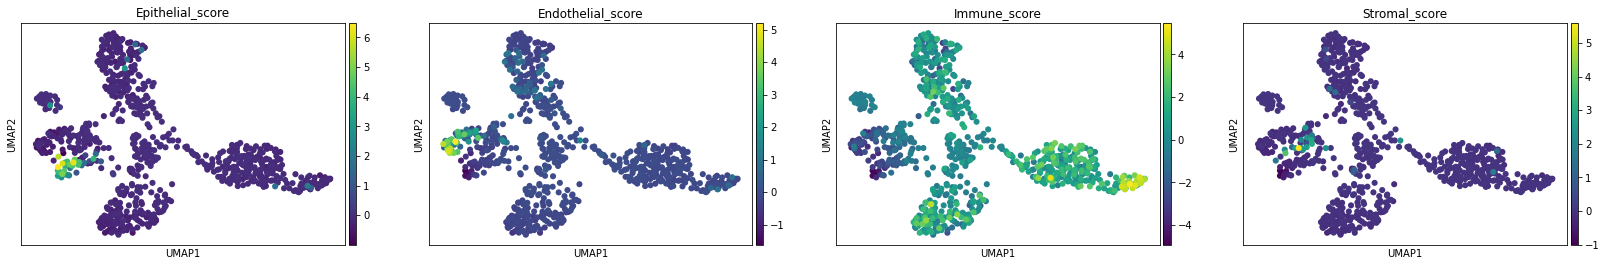

In [19]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# Find markers for each cluster

In [20]:
sc.tl.rank_genes_groups(organ_adata, groupby="leiden", method="wilcoxon")

In [21]:
def FormatDE(res):
    groups = res['scores'].dtype.names
    df_res = {}
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        df_res[group] = df
    return df_res


In [22]:
DE = FormatDE(organ_adata.uns["rank_genes_groups"])

### top positive marker genes

In [23]:
for x in DE.keys():
    print(x)
    display(DE[x].T[:20])

0


wilcoxon_score  log fold change  adjusted pvalue
CCL22          14.680666        14.061841     5.047740e-44
HLA-DPB1       14.629339         9.396195     5.373371e-44
CD74           14.562917        11.422885     9.487859e-44
HLA-DPA1       14.542538        10.338311     9.585948e-44
HLA-DRB1       14.518887         9.691249     1.083115e-43
HLA-DRA        14.506307        11.536077     1.084314e-43
HLA-DQA1       14.351824         8.161959     8.727229e-43
HLA-DQA2       14.278859         7.674036     2.181229e-42
CST7           14.258983         9.716658     2.578224e-42
HLA-DQB1       14.137963         7.003281     1.304600e-41
CCR7           14.085881        11.681547     2.482360e-41
HLA-DQB2       14.010653         7.629402     6.581963e-41
HLA-DRB6       13.912780         6.407013     2.399157e-40
C15orf48       13.802075        10.092289     1.041238e-39
CD83           13.776412         9.996010     1.386992e-39
MTSS1          13.724079         7.700968     2.680377e-39
GPR183         13.679545         8.219600     4.658703e-39
DUSP5          13.670740         8.467593     4.966124e-39
CXCL16         13.586453         8.727572     1.493036e-38
KYNU           13.484052         8.411362     5.714661e-38

1


wilcoxon_score  log fold change  adjusted pvalue
CXCR4         10.491674         6.710933     5.553901e-21
PTPRC          9.531265         4.971880     4.573566e-17
RPS27          9.054663         2.344378     2.688204e-15
RPS19          8.946321         2.809482     5.409084e-15
CNOT6L         8.813531         4.188505     1.427766e-14
SARAF          8.705190         4.580708     3.110743e-14
RPS16          8.607398         2.967124     6.207709e-14
IL7R           8.593502         5.235908     6.207709e-14
FYN            8.559790         4.403477     7.396272e-14
RNF19A         8.347738         4.240221     3.847601e-13
TSC22D3        8.343878         4.959100     3.847601e-13
RPL13A         8.228330         2.722358     9.313302e-13
IFITM1         8.174288         5.430501     1.347755e-12
ARHGDIB        7.860842         5.176612     1.604456e-11
RPL41P1        7.802682         2.375074     2.378542e-11
RPL21          7.772316         2.538805     2.835475e-11
RPL23A         7.666032         2.695004     6.143196e-11
TXNIP          7.628717         3.845450     7.754500e-11
PRDM1          7.593462         3.558915     9.650683e-11
HMGB2          7.476370         4.226129     2.248947e-10

2


wilcoxon_score  log fold change  adjusted pvalue
TPSAB1        13.184537        12.712904     3.393970e-35
TPSB2         13.179400        12.959132     3.393970e-35
CPA3          13.103154        10.586658     6.198060e-35
HDC           12.905241         9.749009     6.188714e-34
KIT           12.687319         8.011344     8.185916e-33
IL1RL1        12.571057         8.569695     2.988837e-32
RGS2          12.501842         9.171319     6.134371e-32
PHACTR4       12.244987         7.462923     1.315063e-30
MELTF         12.200915         9.381742     2.010409e-30
HPGD          12.052209         8.144096     1.111584e-29
ASAH1         11.858081         7.338305     1.045764e-28
CPM           11.747227         7.609599     3.580003e-28
CTSG          11.651785         9.434183     1.017557e-27
HPGDS         11.595818         9.803699     1.819566e-27
RNF130        11.481990         6.446624     6.377480e-27
CALB2         11.364918         8.564615     2.300472e-26
MPP1          11.327606         7.544031     3.317054e-26
LAPTM4A       10.975038         6.532693     1.632771e-24
GATA2         10.970983         7.498322     1.632771e-24
CAPG          10.926100         7.381640     2.545719e-24

3


wilcoxon_score  log fold change  adjusted pvalue
TLR2           10.164377         7.241225     1.683347e-19
CXCL8           9.786821         9.036365     3.775460e-18
C15orf48        9.553318         7.553128     1.869479e-17
PID1            9.552156         6.932802     1.869479e-17
CXCL3           9.496685         8.255435     2.551175e-17
IL1R2           9.335498         7.569651     9.862486e-17
TIMP1           9.121452         7.330301     6.233830e-16
ATP13A3         9.053203         4.655257     1.021658e-15
ETS2            9.036939         5.627931     1.053912e-15
EREG            9.002958         7.572644     1.293467e-15
RNF144B         8.968397         5.568366     1.610147e-15
HLA-DRA         8.867909         7.460228     3.656408e-15
ACSL1           8.735765         5.631576     1.095944e-14
KYNU            8.693653         5.900962     1.475821e-14
CEBPB           8.607977         4.210501     2.918427e-14
HLA-DRB1        8.519687         5.686852     5.886446e-14
MMP19           8.442724         6.756123     1.073605e-13
FCER1G          8.396546         5.969881     1.503815e-13
NAMPT           8.357048         5.188124     1.992510e-13
SOD2            8.350368         5.995551     2.003070e-13

4


wilcoxon_score  log fold change  adjusted pvalue
RF00100-4          8.883883         5.186646     5.589721e-16
RNU6-6P            7.313833         5.384770     1.012207e-10
RNU1-1             5.481526         6.684698     7.454603e-06
RNU1-4             5.300880         6.493315     1.927416e-05
SNORD3A            4.435988         4.834153     1.066304e-03
RNU1-2             4.431922         6.301842     1.080211e-03
RN7SKP9            3.485419         4.487167     3.751852e-02
HIST1H2BG          3.424429         5.048738     4.528009e-02
AC245014.3         3.275150         5.100819     7.170737e-02
RN7SKP203          3.233618         4.198184     8.084350e-02
RN7SL2             3.107282         1.424205     1.182510e-01
PRMT9              3.079692         2.232862     1.273355e-01
AL512646.1         2.965264         1.078919     1.759258e-01
RN7SKP71           2.861581         4.558540     2.325745e-01
RN7SKP255          2.849964         4.381461     2.387795e-01
AL355075.4         2.815984         4.560646     2.607228e-01
HIST1H2BN          2.802334         3.249528     2.688327e-01
RF00003-4          2.679483         4.686060     3.675559e-01
CSKMT              2.670770         2.956950     3.750110e-01
LAMTOR5-AS1        2.608909         4.258269     4.354432e-01

5


wilcoxon_score  log fold change  adjusted pvalue
RGS2            9.588362         8.206279     5.268535e-17
TPSB2           9.144616        10.057853     1.761450e-15
PLIN2           9.012903         6.627767     3.937848e-15
TPSAB1          8.931367         9.636187     6.192770e-15
AKAP13          8.843872         4.989282     1.088591e-14
PHACTR4         8.776134         5.743484     1.660030e-14
HDC             8.325489         6.859193     7.062810e-13
IL1RL1          8.061750         5.979178     5.534482e-12
LMNA            7.920630         5.807279     1.437519e-11
ADGRE2          7.916553         5.673173     1.437519e-11
NDEL1           7.494132         5.589922     3.571723e-10
DDIT4           7.406010         5.112982     6.385233e-10
ASAH1           7.286214         4.767979     1.427349e-09
CD44            7.277747         4.470705     1.427349e-09
CDC42EP3        7.217535         4.561048     2.077644e-09
KIT             7.198720         4.867727     2.236346e-09
PRKX            7.028121         4.646854     6.908198e-09
MPP1            7.026866         5.598947     6.908198e-09
TUBB4B          7.016203         4.736421     7.063712e-09
ELL2            6.995820         3.836004     7.762388e-09

6


wilcoxon_score  log fold change  adjusted pvalue
KLRK1            9.759902         8.441035     9.849938e-18
GNLY             9.383580        12.231600     1.877060e-16
MPZL3            8.939835         5.735880     7.648270e-15
AREG             8.901889         6.408666     8.080544e-15
LINC01871        8.628742         7.888535     7.303472e-14
XCL1             8.350264         9.072678     5.743334e-13
CD96             8.349950         6.103388     5.743334e-13
JAML             8.195659         5.991784     1.833986e-12
XCL2             8.145796         8.965632     2.464662e-12
PGK1             7.998403         4.889789     7.420160e-12
CD53             7.978333         5.485731     7.722739e-12
SEPT11           7.968925         5.772287     7.722739e-12
SMC4             7.961084         5.528268     7.722739e-12
PTPRC            7.909340         4.939368     1.088071e-11
GZMB             7.898364         8.041886     1.109061e-11
SYTL3            7.746895         4.279659     3.464754e-11
PRF1             7.369005         7.999560     5.953005e-10
TMSB4X           7.155443         3.439137     2.643936e-09
FXYD5            7.152307         4.750520     2.643936e-09
ZFP36L2          7.130668         3.856335     2.940053e-09

7


wilcoxon_score  log fold change  adjusted pvalue
HSPB1          10.535963        10.073462     1.529667e-21
TM4SF1         10.524567        12.142960     1.529667e-21
SERPINE1       10.509687        14.687335     1.529667e-21
PNP            10.396986         8.949292     3.766185e-21
TCF4           10.321324         8.477932     6.645125e-21
ADAMTS9        10.227935        11.679661     1.279121e-20
ITGA5          10.225718         8.737002     1.279121e-20
HLA-B          10.116817         5.157756     3.424049e-20
IFITM3         10.075662         7.369483     4.629969e-20
SPARC           9.998101        12.395021     9.091933e-20
DSTN            9.989237         7.756907     9.091933e-20
EEF1A1          9.946815         3.478442     1.277392e-19
CD59            9.927821         6.473265     1.426762e-19
IFI27           9.903444        10.657405     1.691164e-19
EEF1A1P5        9.873054         3.108153     2.138179e-19
CAV1            9.860391        10.691849     2.274174e-19
EEF1A1P6        9.841712         3.234905     2.577574e-19
RHOB            9.832532         7.330396     2.666900e-19
ESAM            9.811321        13.630449     3.118323e-19
POMP            9.772698         6.434824     4.306924e-19

8


wilcoxon_score  log fold change  adjusted pvalue
YBX3            6.833353         4.128568     1.220852e-07
IFITM3          6.090878         4.186372     1.101782e-05
NNMT            5.561784         6.003811     1.429100e-04
MT1E            5.468490         4.185455     2.226683e-04
AXL             5.413289         4.665971     2.802100e-04
MT1M            5.383913         5.860610     3.064766e-04
MT2A            5.113071         3.758833     1.147477e-03
SELENOM         5.059161         4.368927     1.377251e-03
IL6             4.722464         7.804312     6.531879e-03
GEM             4.671460         5.131961     7.335867e-03
C11orf96        4.660484         5.556516     7.428618e-03
ZFP36L1         4.639178         2.619742     7.626886e-03
IGFBP7          4.573324         4.235086     9.421186e-03
APOD            4.559765         6.400336     9.421186e-03
GPX3            4.482290         3.797295     1.242096e-02
MAP1B           4.390610         5.542952     1.751119e-02
PMP22           4.379634         3.617409     1.794456e-02
MT1A            4.336700         5.551719     2.076787e-02
ELOC            4.317977         2.532759     2.207148e-02
MORF4L2         4.252445         2.906437     2.766221e-02

9


wilcoxon_score  log fold change  adjusted pvalue
RORA            8.209581         6.126165     9.002937e-12
CNOT6L          8.127542         4.762820     9.002937e-12
CXCR4           8.121941         6.552656     9.002937e-12
IL7R            7.923925         6.024716     3.386916e-11
CD69            7.184908         5.667264     7.918317e-09
SARAF           7.075851         4.554939     1.457371e-08
TXNIP           7.047845         4.648990     1.528177e-08
CRYBG1          6.992493         4.174561     1.987184e-08
PRDM1           6.788218         3.842437     6.760093e-08
FYB1            6.786570         4.709951     6.760093e-08
TSC22D3         6.698270         5.194471     1.128705e-07
TRBC1           6.650496         4.632403     1.380249e-07
ZFP36L2         6.644236         3.690873     1.380249e-07
PTPRC           6.564832         4.298506     2.190453e-07
NR3C1           6.368134         4.149432     6.476621e-07
RNF19A          6.367146         4.049140     6.476621e-07
HMGB2           6.366157         4.585956     6.476621e-07
LEPROTL1        6.362862         4.308779     6.476621e-07
ITK             6.125968         4.633543     2.792723e-06
IFITM1          6.112460         5.079167     2.887782e-06

10


wilcoxon_score  log fold change  adjusted pvalue
CD163           6.624154         6.559446     8.566656e-08
RNASE1          6.139771         5.938542     1.158342e-06
CTSL            5.297573         4.217660     8.400573e-05
C1QC            5.013810         4.178181     3.020636e-04
TLR2            4.930331         3.727739     4.456620e-04
ANPEP           4.903738         4.205380     4.986962e-04
ACSL1           4.891284         3.610476     5.219131e-04
MARCO           4.815210         5.505060     7.095535e-04
C1QB            4.648251         4.148499     1.449072e-03
CXCL1           4.587325         4.089853     1.835444e-03
CXCL5           4.397813         4.239206     4.074215e-03
LAMP1           4.352707         2.813658     4.916799e-03
CXCL3           4.343282         3.833964     5.100960e-03
SLC16A10        4.311641         2.380437     5.678412e-03
DMXL2           4.269901         4.098230     6.616430e-03
MAFB            4.268555         3.248483     6.618450e-03
TGFBI           4.264852         3.683948     6.673218e-03
CCL3            4.259466         4.414064     6.777178e-03
SLC11A1         4.241962         4.124521     7.206650e-03
FCER1G          4.241962         3.159170     7.206650e-03

11


wilcoxon_score  log fold change  adjusted pvalue
TRBC1           6.942035         5.871065     1.600997e-07
FYN             6.893618         4.832329     1.600997e-07
PTPRC           6.631332         4.625720     6.528094e-07
FYB1            6.419553         4.955508     2.011510e-06
ARHGDIB         5.914140         5.096265     3.273313e-05
PRDM1           5.858060         3.395406     3.938445e-05
CLEC2D          5.784564         4.703925     5.349844e-05
CXCR4           5.719080         5.016216     7.005679e-05
TRAC            5.656731         5.574749     9.082672e-05
PDCD4           5.424052         3.370587     2.858276e-04
NOP58           5.265566         3.937306     6.328878e-04
CD2             5.230734         5.519348     6.354206e-04
IL32            5.228296         4.506252     6.354206e-04
SRSF7           5.226554         3.871063     6.354206e-04
LEPROTL1        5.123800         3.864565     9.793316e-04
CYTIP           4.905054         4.145276     2.618355e-03
IKZF3           4.864301         4.764011     3.073607e-03
TRBC2           4.485328         4.111693     1.530661e-02
CTLA4           4.425068         6.704769     1.891922e-02
IFI16           4.387101         2.986619     2.123446e-02

12


wilcoxon_score  log fold change  adjusted pvalue
RPS27             3.962705         1.475860         0.024237
AC005912.1        3.889183         1.344082         0.030680
BX679664.1        3.799243         1.605499         0.041884
AC099336.2        3.128264         1.595121         0.260096
AC090602.1        3.015125         1.711114         0.346044
RPS27P21          2.887354         1.458086         0.453786
AC099560.2        2.790633         1.030863         0.553012
AC002075.2        2.750659         1.328694         0.590442
RPL35A            2.293108         1.418222         1.000000
CD3D              2.156414         2.840936         1.000000
CXCR4             2.106091         1.842597         1.000000
RPL21P28          1.959403         0.747268         1.000000
MRPL1             1.952979         1.957620         1.000000
SYNE1             1.583583         2.133791         1.000000
AC005884.2        1.504351         0.821183         1.000000
RPL21             1.450815         0.328549         1.000000
RPL23AP2          1.444748         0.742603         1.000000
RPL21P18          1.414054         1.032448         1.000000
RPS29             1.369441         0.577132         1.000000
IFITM1            1.295205         1.305818         1.000000

13


wilcoxon_score  log fold change  adjusted pvalue
TACSTD2         8.535147        11.910557     8.240480e-13
MT-CO3          8.412973         4.277176     1.176651e-12
MTCO3P12        8.218869         3.870443     4.031226e-12
MT1X            8.085130         7.063005     6.639753e-12
MT-ND4          8.077900         4.545150     6.639753e-12
MTATP6P1        8.074647         4.180534     6.639753e-12
MT-ATP6         8.041393         4.480340     7.470010e-12
CD24            8.013199        11.727737     8.224325e-12
SOD2            7.852711         7.156495     2.396828e-11
MT-ATP8         7.825240         3.756165     2.711708e-11
AZGP1           7.770298        14.854043     3.841345e-11
NAMPT           7.729815         5.945647     4.877300e-11
SDC4            7.715356         7.071029     5.073110e-11
MT-RNR2         7.694392         3.577956     5.579658e-11
MT-ND4L         7.598605         4.229455     1.101385e-10
CNN3            7.578724         7.062573     1.208457e-10
MT-RNR1         7.557037         4.544032     1.348629e-10
TSC22D1         7.507155         6.978238     1.872249e-10
MT-ND3          7.464503         5.498976     2.461190e-10
KRT7            7.387874        10.517242     4.182438e-10

14


wilcoxon_score  log fold change  adjusted pvalue
MT1X              5.193491         4.331287         0.000184
LDHA              4.028550         3.587519         0.020466
TSC22D1           3.853395         3.051732         0.037474
VAMP8             3.817043         3.675131         0.040361
S100A16           3.592730         4.035057         0.078629
PRELID1           3.381222         3.183646         0.145490
SPTSSA            3.282905         3.620847         0.190763
IDH2              3.104445         4.114586         0.295335
MT1XP1            2.795447         1.495973         0.595921
PDK3              2.593441         3.420641         0.922149
HMGA1             2.410438         2.085956         1.000000
MT2A              2.410025         2.587206         1.000000
SOD2              2.246437         1.259590         1.000000
AC016734.1        2.233218         1.751328         1.000000
SERPINB1          2.138618         2.159814         1.000000
AKR1C1            2.133661         3.682293         1.000000
KRT18             2.008078         2.294999         1.000000
RPL8              1.935373         1.746596         1.000000
PDLIM4            1.868864         2.170608         1.000000
TPD52L1           1.852340         3.282788         1.000000

15


wilcoxon_score  log fold change  adjusted pvalue
IL1RL1          3.722843         3.611056         0.543861
TPSAB1          3.639742         5.743297         0.600707
TPSB2           3.636028         5.666260         0.600707
KIT             3.155062         2.667732         1.000000
HPGD            3.096566         3.063710         1.000000
PHACTR4         2.929435         2.281105         1.000000
MELTF           2.734913         3.080701         1.000000
CPA3            2.553390         2.470271         1.000000
RGS2            2.503715         2.806875         1.000000
CTSG            2.297587         3.172295         1.000000
HDC             2.226556         2.375774         1.000000
LMNA            1.951719         1.859293         1.000000
ACYP1           1.833798         2.565481         1.000000
LGALS3          1.738162         1.621158         1.000000
FCER1G          1.698237         2.189313         1.000000
FUNDC2          1.645312         1.899190         1.000000
ARHGAP18        1.627206         0.684094         1.000000
BATF            1.590530         1.991523         1.000000
CAPG            1.545962         1.610594         1.000000
PPP2R5A         1.536212         2.055432         1.000000

16


wilcoxon_score  log fold change  adjusted pvalue
BRD2            4.410514         4.357126         0.208322
GADD45B         4.369913         6.231227         0.208322
NR4A1           4.330561         5.555762         0.208322
MIDN            4.216878         3.672239         0.208322
PPP1R15A        4.063220         4.106413         0.259031
FOS             3.840227         5.869552         0.425668
HSPB1           3.677198         4.839161         0.555285
IER2            3.409232         3.170987         0.958788
FOSB            3.379249         4.415055         0.972479
FGL2            3.323657         4.012042         1.000000
SNHG5           3.321784         4.115586         1.000000
SRSF3           3.293675         3.784708         1.000000
ZFAND2A         3.217470         4.545921         1.000000
JUN             3.185614         3.540031         1.000000
KLF10           3.169998         4.186323         1.000000
RASGEF1B        3.164377         4.346456         1.000000
SERTAD1         3.152509         4.060462         1.000000
NR4A2           3.131896         3.722314         1.000000
FILIP1L         3.117529         4.293693         1.000000
DNAJB1          3.103787         4.335717         1.000000

### for cluster 0 plot the top marker genes

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



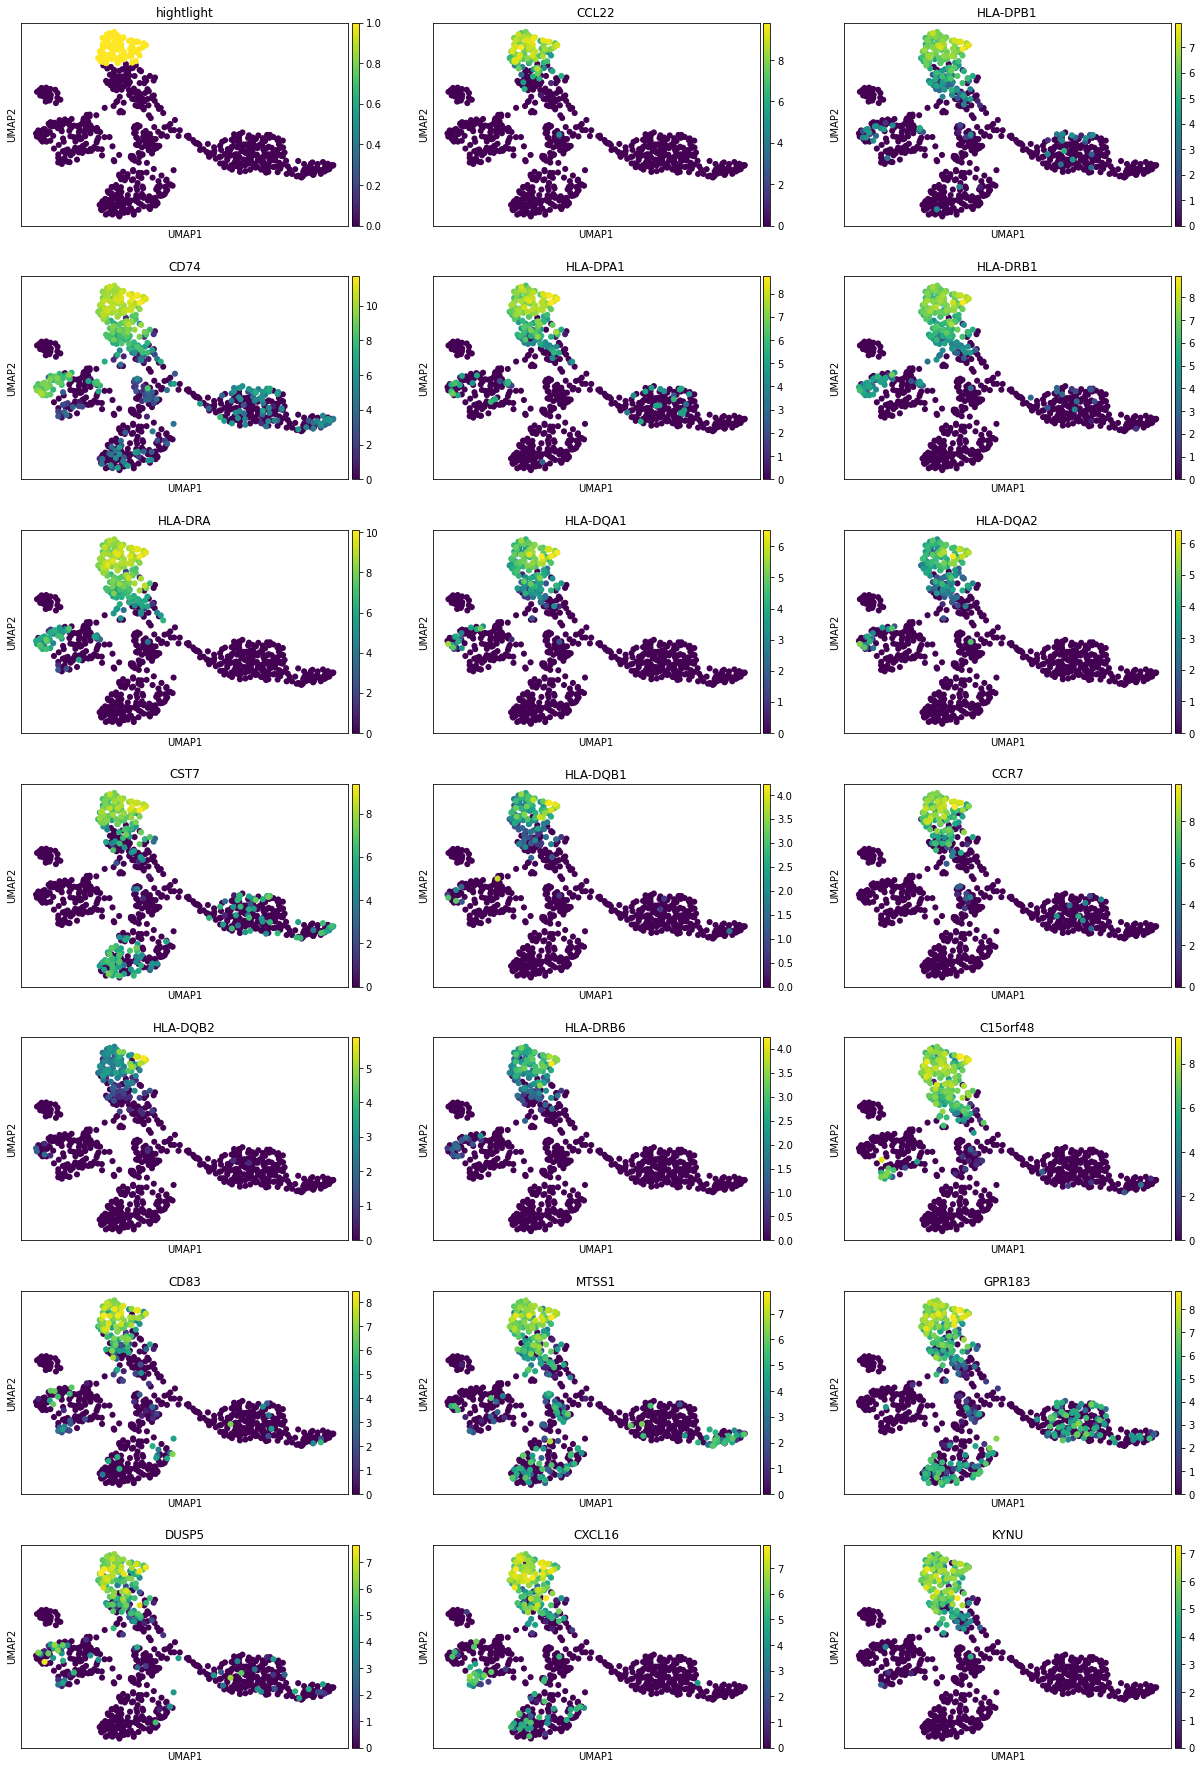

In [24]:
topgenes = list(DE["0"].T[:20].index)
organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == "0"
sc.pl.umap(
    organ_adata,
    color=["hightlight"] + topgenes,
    ncols=3,
)

You can do this for other clusters as well. Here I plot the top 5 genes for all other clusters

0


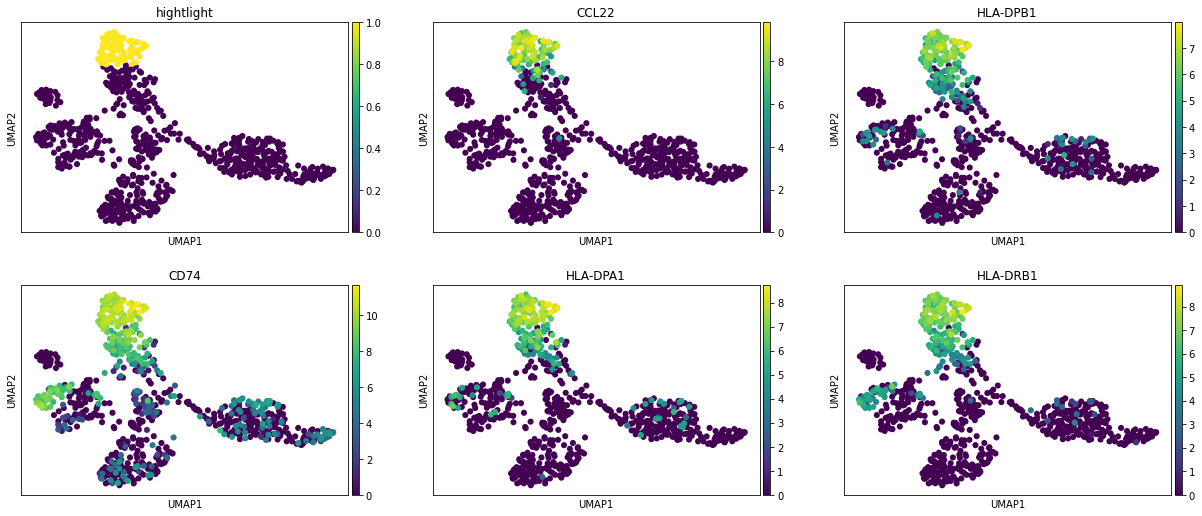

1


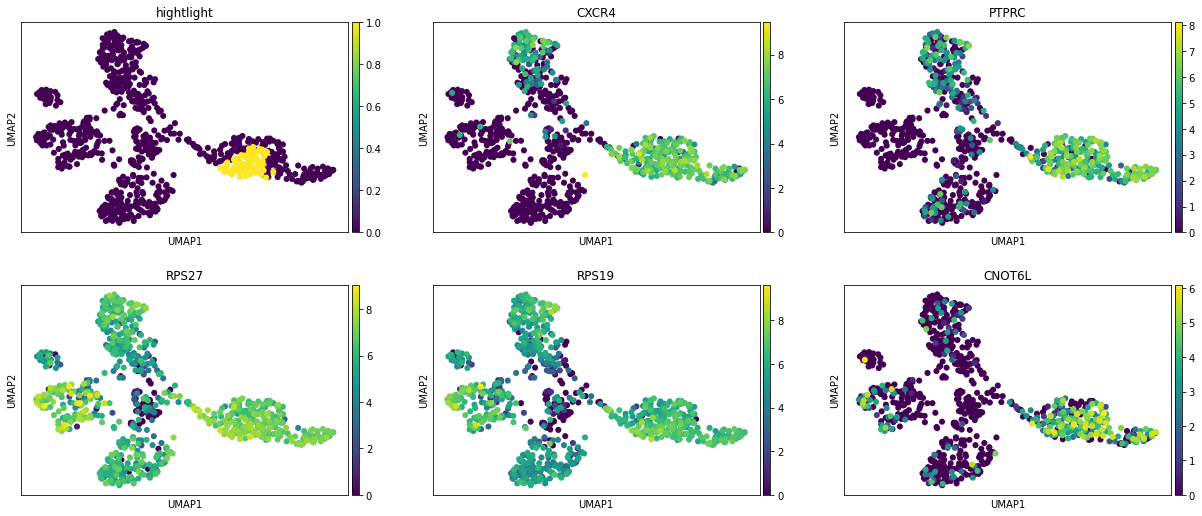

2


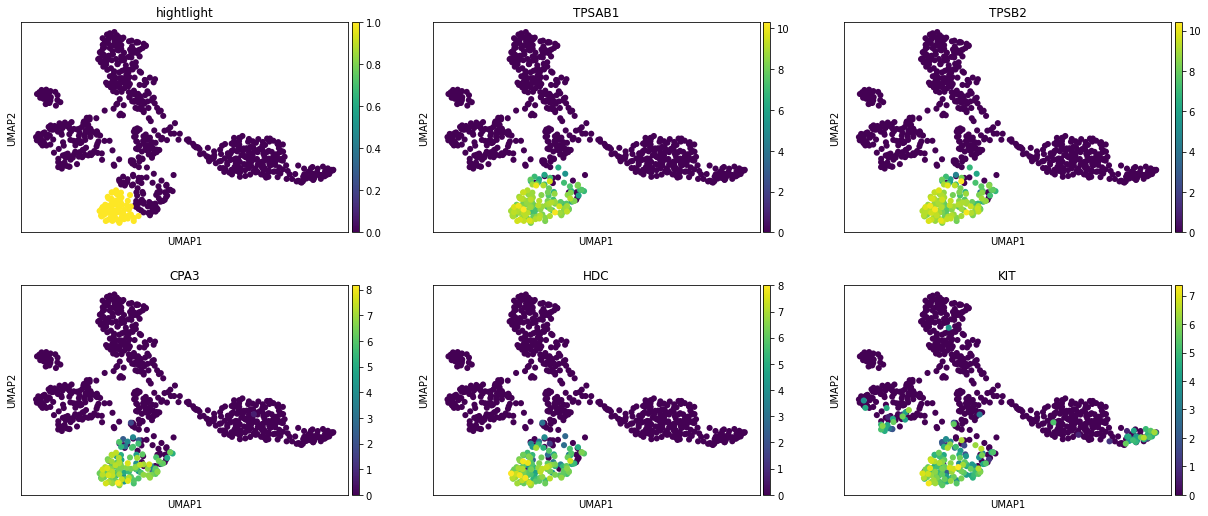

3


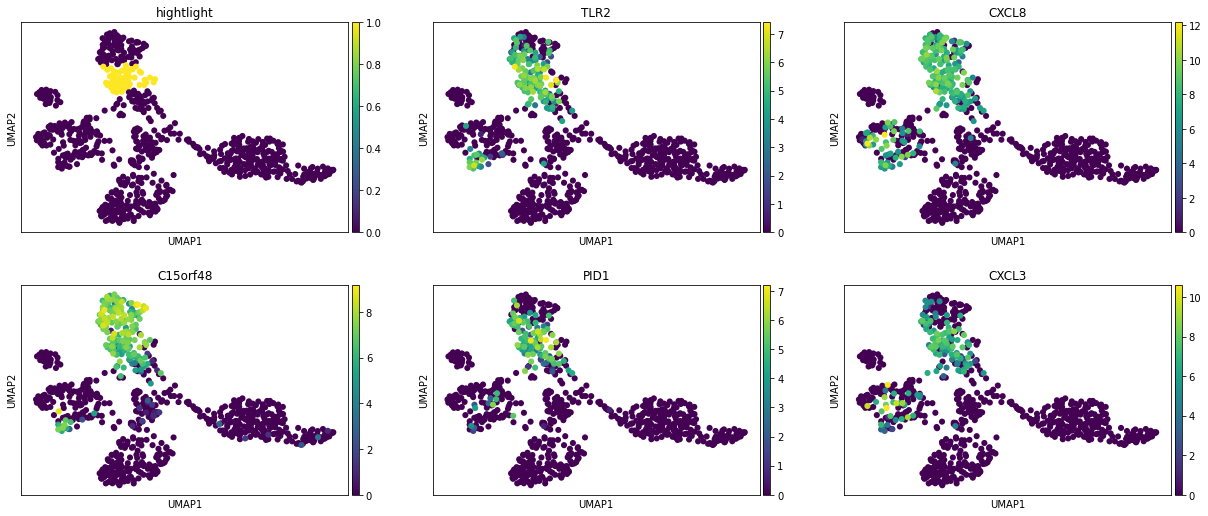

4


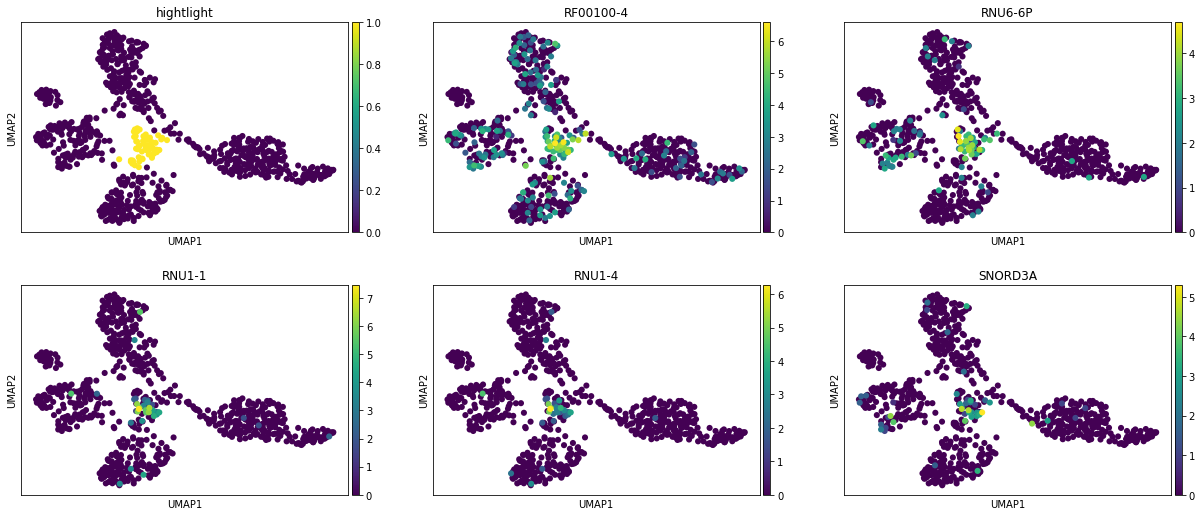

5


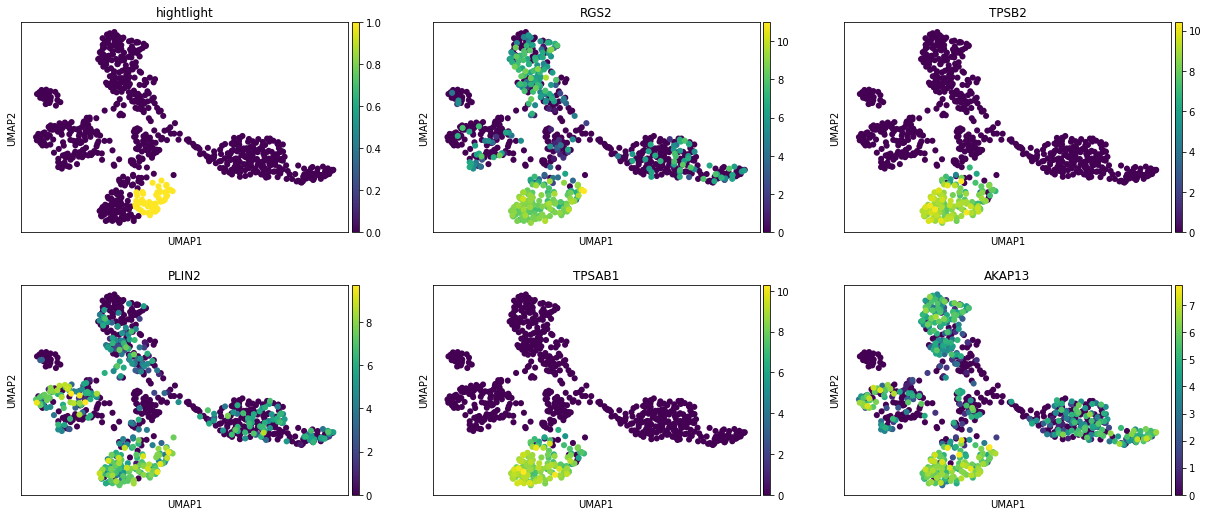

6


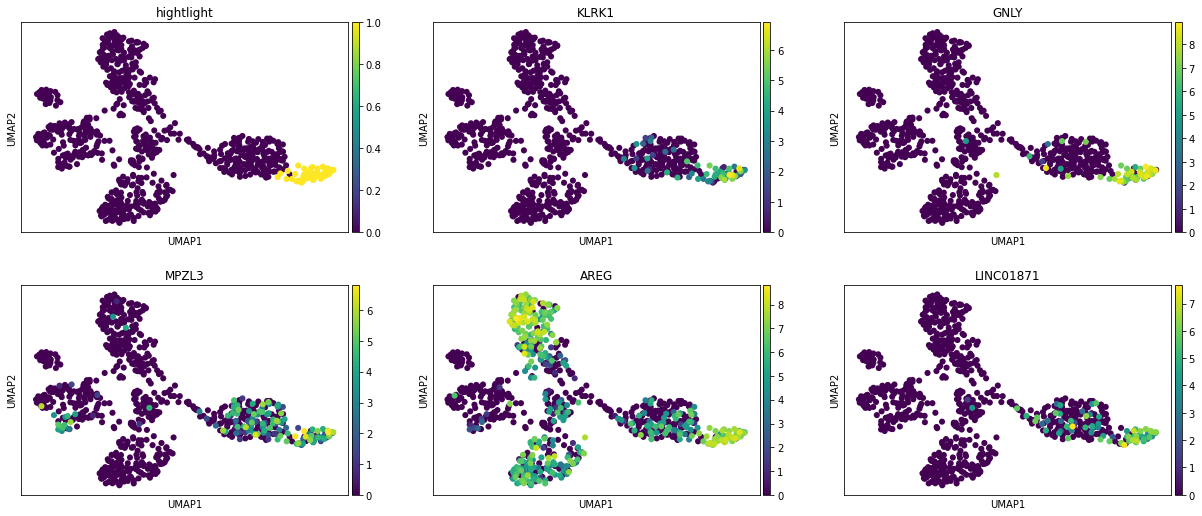

7


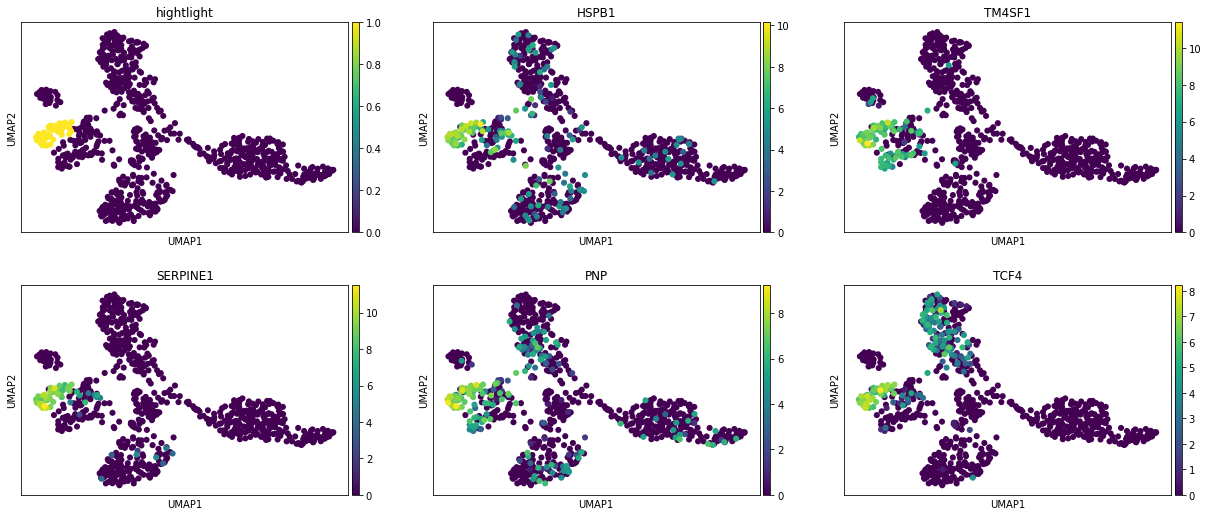

8


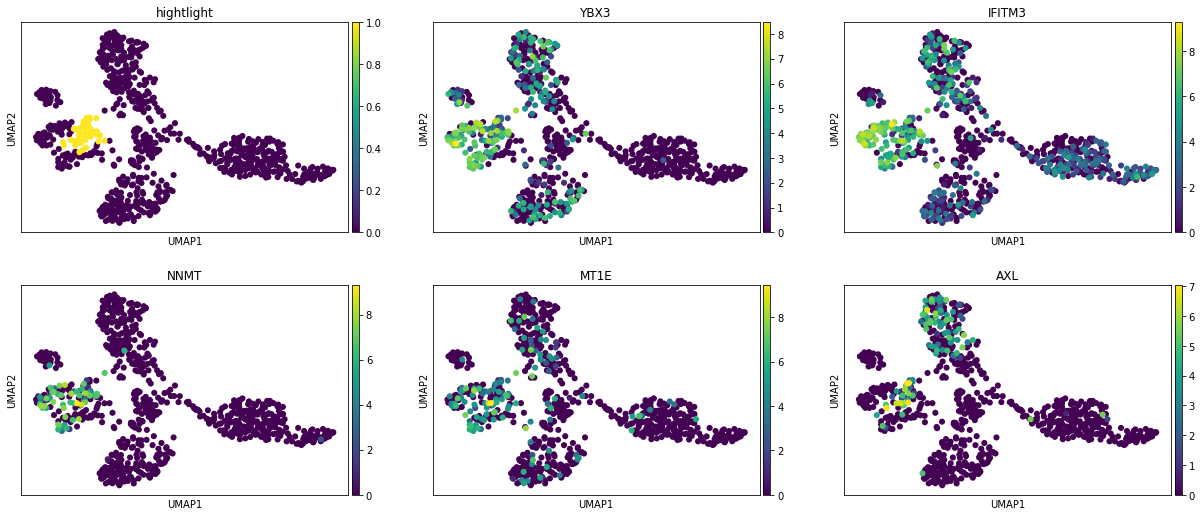

9


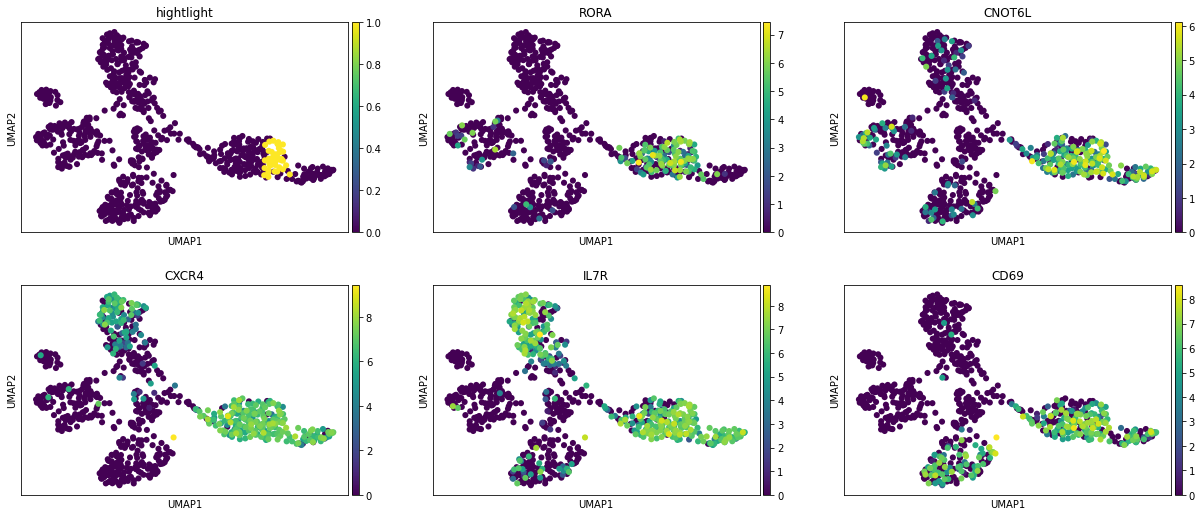

10


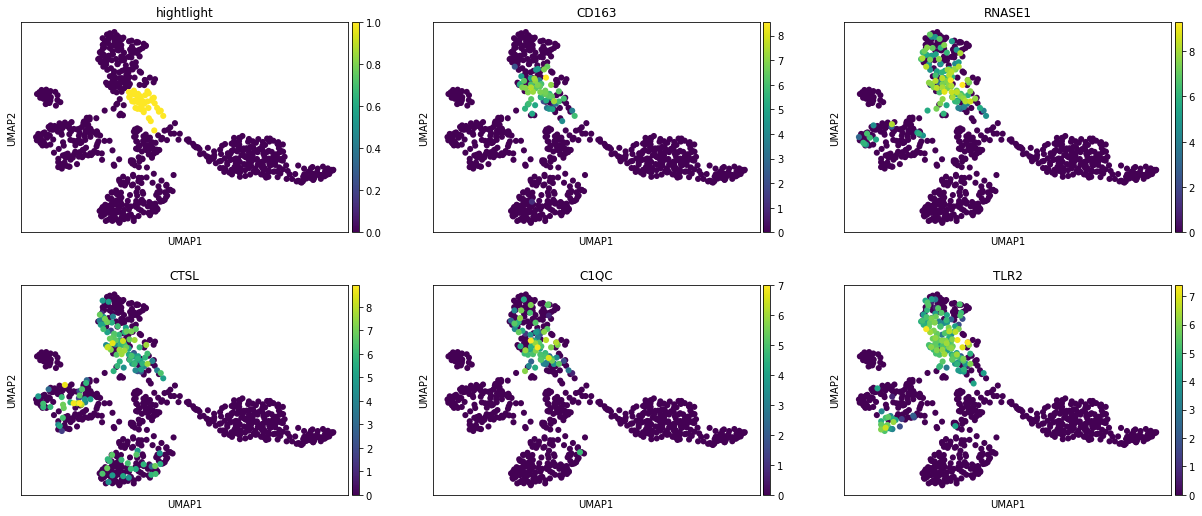

11


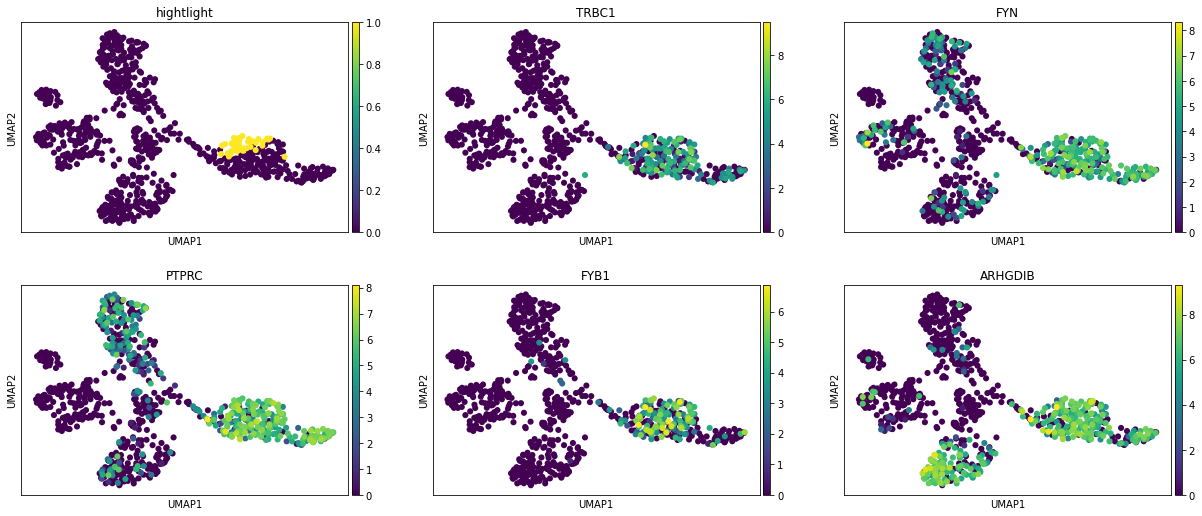

12


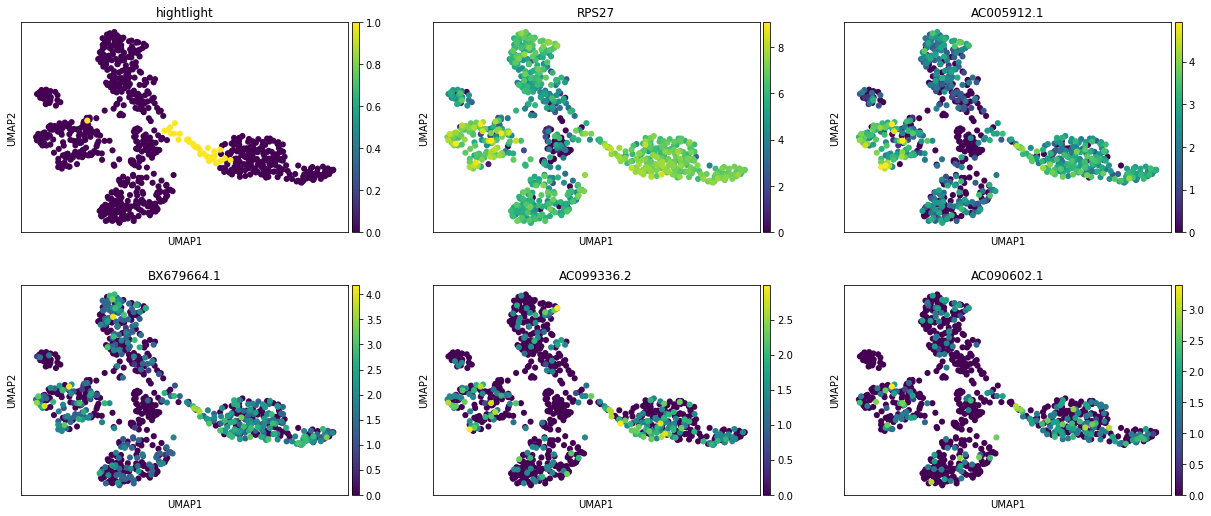

13


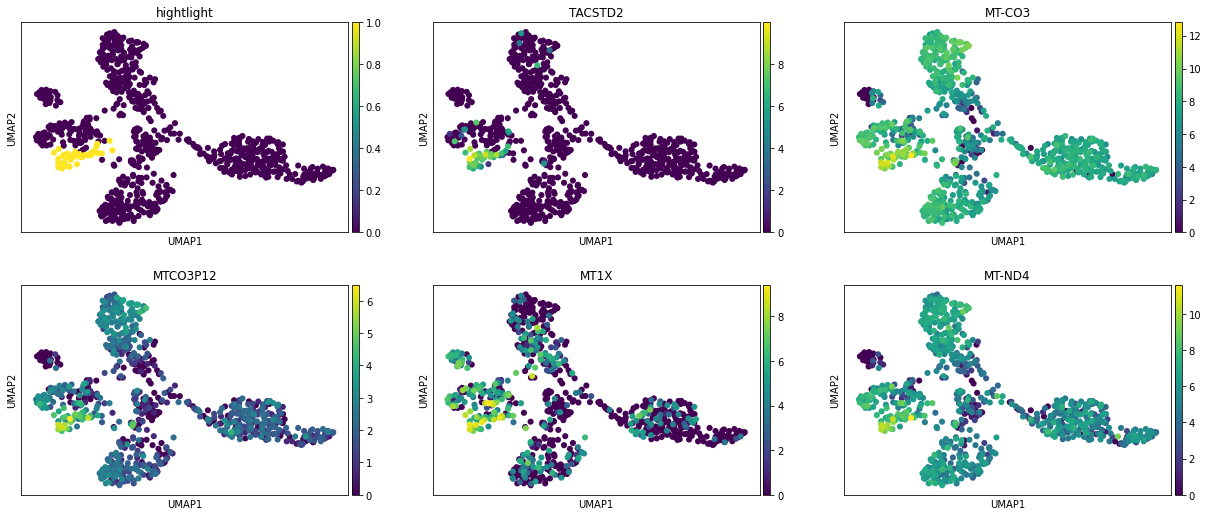

14


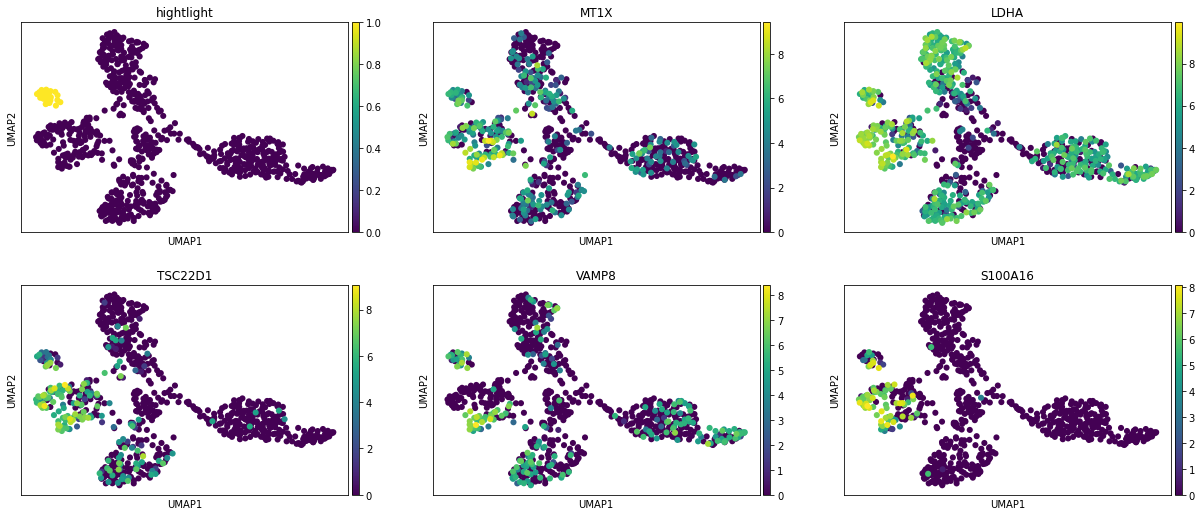

15


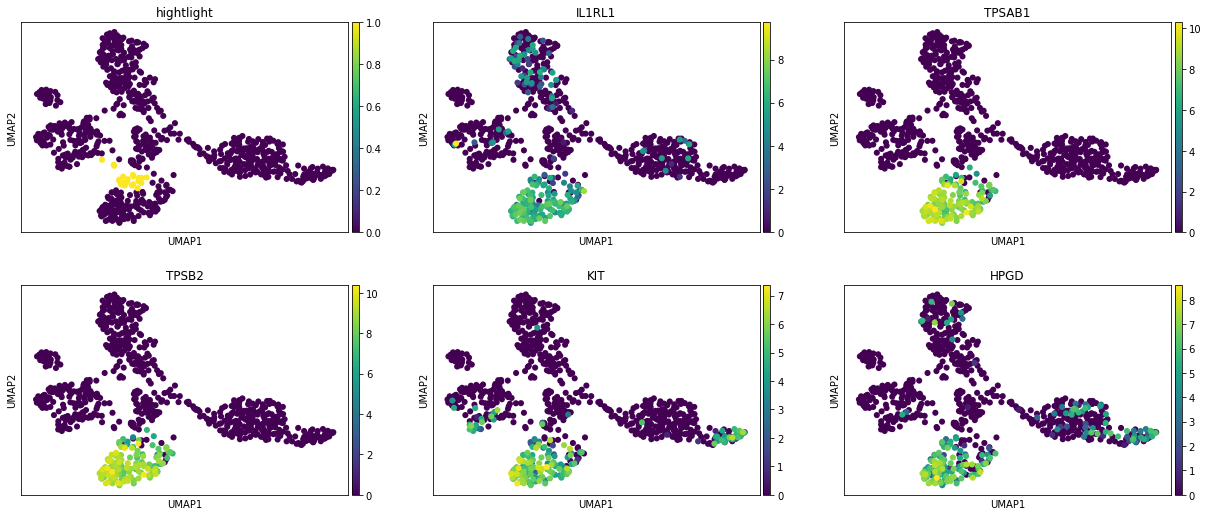

16


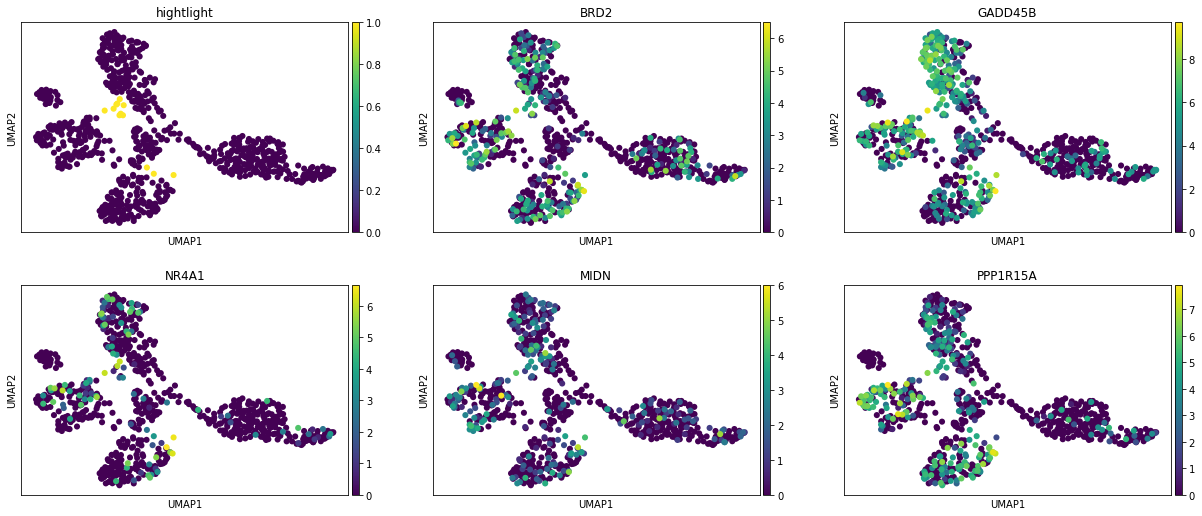

In [25]:
for x in DE.keys():
    print(x)
    topgenes = list(DE[x].T[:5].index)
    organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == x
    sc.pl.umap(
        organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

### The extended DE list can be queried by 

In [26]:
DE["0"].T

wilcoxon_score  log fold change  adjusted pvalue
CCL22          14.680666        14.061841     5.047740e-44
HLA-DPB1       14.629339         9.396195     5.373371e-44
CD74           14.562917        11.422885     9.487859e-44
HLA-DPA1       14.542538        10.338311     9.585948e-44
HLA-DRB1       14.518887         9.691249     1.083115e-43
...                  ...              ...              ...
IFI16          -5.033278        -6.055362     4.223219e-05
NOP58          -5.082843        -3.889991     3.331725e-05
IFITM2         -5.293936        -2.942242     1.136676e-05
ARHGDIB        -6.108621        -7.237808     1.253432e-07
ZFP36L2        -8.039658        -5.534007     2.266483e-13

[58870 rows x 3 columns]

# read in cell ontology 

In [27]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [28]:
celltype_dict['T cell']

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [29]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-intermediate, CD8-positive double-positive thymocyte',
 'activated CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell, human',
 'mature CD4 single-positive thymocyte',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'CD4-negative, CD8-negative type I NK T cell',
 'CD4-positive type I NK T cell secreting interleukin-4',
 'effector CD4-positive, alpha-beta T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'CD4-positive, alpha-beta thymocyte',
 'CD4-positive, alpha-beta memory T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'central memory CD4-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta intraepithelial T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-negative, CD8-negative, alpha-beta intraepithelial T cell',
 'CD4-negative CD8-negative gamma-delta intraepithelial T cell',
 'CD69-positive, CD4-

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [30]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()
cluster_mapping = {"0": "T cell"}
cluster_markers = {"0": ["CXCR4", "CD3D", "IL7R", "IL32"]}

This cell will automatically replace the leiden cluster names with cell type annotations

In [31]:
for l in cluster_mapping.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, cluster_mapping[l], inplace=True)
    display(DE[l][cluster_markers[l]])

CXCR4       CD3D          IL7R      IL32
wilcoxon_score   4.270172  -1.569235  6.909215e+00 -2.428704
log fold change  2.785596 -29.534359  3.958235e+00 -2.715858
adjusted pvalue  0.001296   1.000000  7.881844e-10  0.497796

# Visualize the results of the manual annotation

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



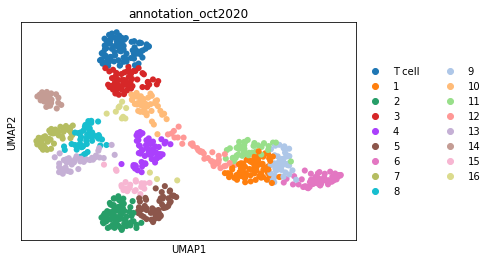

In [32]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# manually create mapping between cell type and compartment (this is just an example)

In [33]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()
compartment_mapping = {"T cell": "Immune"}

This cell will automatically replace the leiden cluster names with cell type annotations

In [34]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

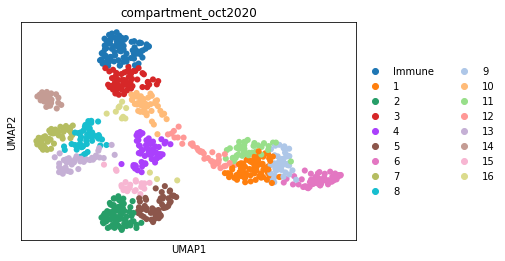

In [35]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [36]:
organ_adata.write_h5ad(
    data_path + "decontX/organ_data/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)